### aim: calculate vertical gradients in c14


some old useful things could be in /gpfs/home/mep22dku/scratch/SOZONE/C14/make_verticalgradient.ipynb

### date: 

In [58]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [59]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [60]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

great to hear you have solved the 1985 problem. Arg indeed for the make_c14gradient_one.jnl, it is in the folder here: /gpfs/home/e415/scratch/c14 (and pasted below for convenience)



        let c14 = if c14b lt 1e10 then c14b ! remove continents 

        let c14so = c14[j=2:47@ave,i=2:181@ave] 

        let dc14dz = c14so[k=17] - c14so[k=1] ! z=217m minus z=5m 



        let ccc = if dic lt 1e10 then dic ! remove continents 

        let dicso = ccc[j=2:47@ave,i=2:181@ave] 

        let ddicdz = dicso[k=17] - dicso[k=1] ! z=217m minus z=5m 



        !list/file=dc14dz.txt/append/noh/format=(f12.3) dc14dz 

        !save/file=dc14dz.nc/append dc14dz 

        save/file=dc14dz.nc/append ddicdz 

        can data/all 

 

## look at corinne's vertical gradient 

Text(0.5, 1.0, 'bomb c14 gradient in CLQ run')

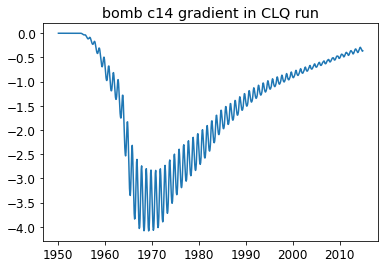

In [61]:
dc14dzf = './corinneData/dc14dz.nc'
CLQ_dc14dz  = xr.open_dataset(dc14dzf)
times = pd.date_range("1950/01/01","2014/12/01",freq='MS')
CLQ_dc14dz['TIME_COUNTER'] = times

plt.plot(CLQ_dc14dz.TIME_COUNTER,CLQ_dc14dz.DC14DZ)
plt.title('bomb c14 gradient in CLQ run')

In [62]:

extract = False

if extract:
    
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    tmask = tmesh.tmask[0,0,:,:] 
    area_surface = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    area_16 = tmesh.tmask[0,16,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    yrst = 1960; yrend = 1970
    tr = 'GEC4'
    trs = ['GEA4']#,'GEC4']#,'C405', 'C4C5']
    for tr in trs:
        for yr in range(yrst,yrend):

            baseDir = '/gpfs/data/greenocean/software/runs/'
            dtype = 'ptrc'
            ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yr}*{dtype}*.nc'
            
            try:
                t2 = glob.glob(ty)
                w = xr.open_dataset(t2[0])
                DIC_L17 = w.DIC.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DIC_L1 = w.DIC.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DDICDZ = DIC_L17-DIC_L1
                
                B14B_L17 = w.B14B.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                B14B_L1 = w.B14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DB14DZ = B14B_L17-B14B_L1 
                
                C14B_L17 = w.C14B.isel(deptht = 16).isel(y = slice(0,47)).weighted(area_16.isel(y = slice(0,47))).mean(dim = ['y','x'])
                C14B_L1 = w.C14B.isel(deptht = 0).isel(y = slice(0,47)).weighted(area_surface.isel(y = slice(0,47))).mean(dim = ['y','x'])
                DC14DZ = C14B_L17-C14B_L1 
                
                
                print(f'{tr} {yr}: B14-grad {np.nanmean(DB14DZ)}, C14-grad {np.nanmean(DC14DZ)} DIC-grad {np.nanmean(DDICDZ)}')



                savenam = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{tr}_dc14dz_y{yr}.nc'
                data_vars = {'DC14DZ':(['time_counter'], DC14DZ.values,
                {'units': '',
                'long_name':'DC14DZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),

                 'DDICDZ':(['time_counter'], DDICDZ.values,
                {'units': '',
                'long_name':'DDICDZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),            
                
                'DB14DZ':(['time_counter'], DB14DZ.values,
                {'units': '',
                'long_name':'DB14DZ (lev16-lev0, y = slice(0,47), mean, python indexing)'}),

                }
                # define coordinates
                coords = {'time_counter': (['time_counter'], DC14DZ.time_counter),

                }
                # define global attributes
                attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
                'desc': 'yearly medusa files, saving only variables of interest'
                }
                ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

                ds
                ds.to_netcdf(savenam)
                
            except:
                
                print(f'NO FILE MADE FOR {tr} -- {yr}')
    
# tin

In [63]:
extract = False

if extract:
    
    tmeshf = '/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc'
    tmesh = xr.open_dataset(tmeshf)
    tmesh['dmask'] = tmesh['tmask'].copy()
    dmask = np.zeros([1,31,149,182])

    for i in range(0,31):
        dmask[0,i,:,:] = tmesh.tmask[0,i,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]

    tmesh['dmask'].data = dmask
    tmesh = tmesh.rename({'z': 'deptht'})
#     print(tmesh.dmask)

    yrst = 1940; yrend = 2024
    #trs = ['GEC4']
    trs = ['GEA4','GEC4']#,'C405', 'C4C5']
    for tr in trs:
        for yr in range(yrst,yrend):

            baseDir = '/gpfs/data/greenocean/software/runs/'
            dtype = 'ptrc'
            ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yr}*{dtype}*.nc'
            
            try:
                t2 = glob.glob(ty)
                print(t2)
                w = xr.open_dataset(t2[0])
                #DIC_L17 = 
                tdic = w.DIC.isel(y = slice(0,47)).weighted(tmesh.dmask.isel(y = slice(0,47))).\
                mean(dim = ['y','x']).mean(dim = ['time_counter'])
                tdic2 = tdic.isel(t = 0)
                
                tdic = w.B14B.isel(y = slice(0,47)).weighted(tmesh.dmask.isel(y = slice(0,47))).\
                mean(dim = ['y','x']).mean(dim = ['time_counter'])
                tB14B = tdic.isel(t = 0)
                
                tdic = w.C14B.isel(y = slice(0,47)).weighted(tmesh.dmask.isel(y = slice(0,47))).\
                mean(dim = ['y','x']).mean(dim = ['time_counter'])
                tC14B = tdic.isel(t = 0)


                savenam = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{tr}_dp_y{yr}.nc'
                data_vars = {
                    
                    'DIC':(['deptht'], tdic2.values,
                {'units': '',
                'long_name':' y = slice(0,47), mean, python indexing)'}),

                 'B14B':(['deptht'], tB14B.values,
                {'units': '',
                'long_name':'y = slice(0,47), mean, python indexing)'}),            
                
                'C14B':(['deptht'], tC14B.values,
                {'units': '',
                'long_name':'y = slice(0,47), mean, python indexing)'}),

                }
                # define coordinates
                coords = {'deptht': (['deptht'], w.deptht),

                }
                # define global attributes
                attrs = {'made in':'C14/make_verticalgradient.ipynb',
                'desc': 'variable gradient with time'
                }
                ds = xr.Dataset(data_vars=data_vars,
                coords=coords,
                attrs=attrs)

                ds
                ds.to_netcdf(savenam)
                
            except:
                
                print(f'NO FILE MADE FOR {tr} -- {yr}')
    
# tin



In [64]:
def make_yearlist(yrst, yrend,rnam):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dc14dz_y{yr}.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

GEA4_c = xr.open_mfdataset(make_yearlist(1940,2022,'GEA4'))
GEC4_c = xr.open_mfdataset(make_yearlist(1940,2022,'GEC4'))
C4C5_c = xr.open_mfdataset(make_yearlist(1984,2022,'C4C5'))
C405_c = xr.open_mfdataset(make_yearlist(1984,2022,'C405'))

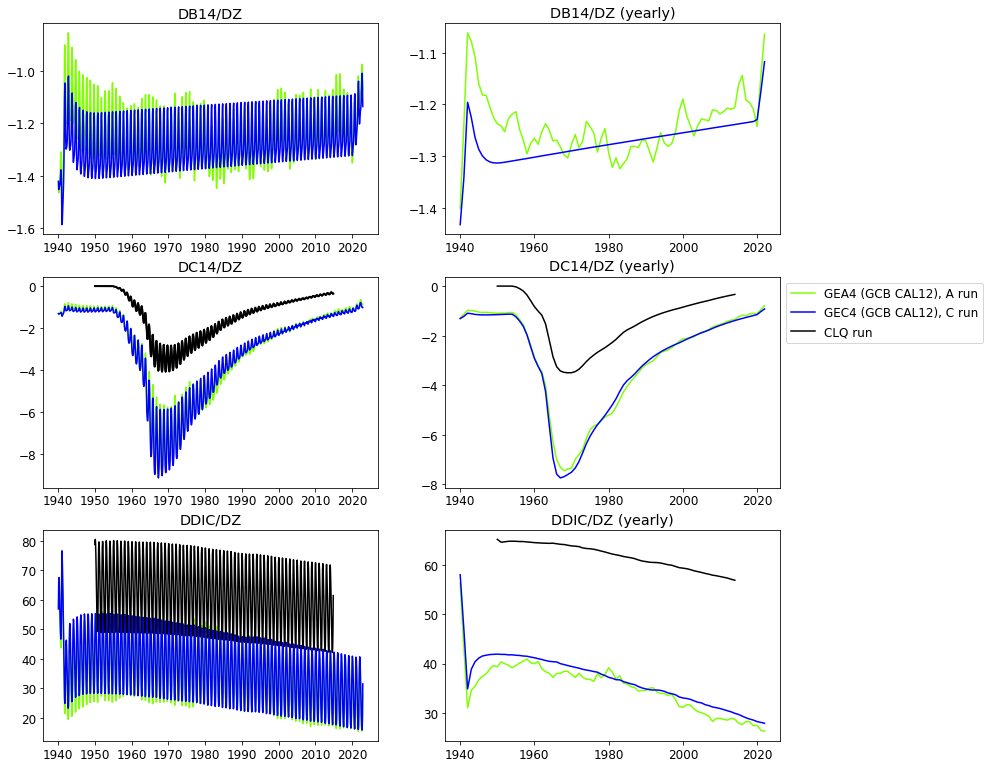

In [65]:
fact = 1.1
tf = 1e6
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, GEA4_c.DB14DZ, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[0].plot(times, GEC4_c.DB14DZ, label = 'GEC4 (GCB CAL12), C run', color = 'b')

times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, GEA4_c.DC14DZ, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[2].plot(times, GEC4_c.DC14DZ, label = 'GEC4 (GCB CAL12), C run', color = 'b')

axs[2].plot(CLQ_dc14dz.TIME_COUNTER,CLQ_dc14dz.DC14DZ, color = 'k', linewidth = 2)

times = GEA4_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, GEA4_c.DDICDZ*tf, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.indexes['time_counter'].to_datetimeindex()
axs[4].plot(times, GEC4_c.DDICDZ*tf, label = 'GEC4 (GCB CAL12), C run', color = 'b')

axs[4].plot(CLQ_dc14dz.TIME_COUNTER,\
            CLQ_dc14dz.DDICDZ*tf, color = 'k', label = 'CLQ,run')
###

times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, GEA4_c.DB14DZ.groupby('time_counter.year').mean(), label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[0+1].plot(times, GEC4_c.DB14DZ.groupby('time_counter.year').mean(), label = 'GEC4 (GCB CAL12), C run', color = 'b')

axs[2].plot(CLQ_dc14dz.TIME_COUNTER,\
            CLQ_dc14dz.DC14DZ, color = 'k', label = 'CLQ,run')


times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, GEA4_c.DC14DZ.groupby('time_counter.year').mean(), label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[2+1].plot(times, GEC4_c.DC14DZ.groupby('time_counter.year').mean(), label = 'GEC4 (GCB CAL12), C run', color = 'b')

axs[2+1].plot(CLQ_dc14dz.TIME_COUNTER.groupby('TIME_COUNTER.year').mean().year,\
            CLQ_dc14dz.DC14DZ.groupby('TIME_COUNTER.year').mean(), color = 'k', label = 'CLQ run')



times = GEA4_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, GEA4_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'GEA4 (GCB CAL12), A run', color = 'chartreuse')
times = GEC4_c.time_counter.groupby('time_counter.year').mean().year
axs[4+1].plot(times, GEC4_c.DDICDZ.groupby('time_counter.year').mean()*tf, label = 'GEC4 (GCB CAL12), C run', color = 'b')

axs[4+1].plot(CLQ_dc14dz.TIME_COUNTER.groupby('TIME_COUNTER.year').mean().year,\
            CLQ_dc14dz.DDICDZ.groupby('TIME_COUNTER.year').mean()*tf, color = 'k', label = 'CLQ run')


axs[3].legend(bbox_to_anchor = [1,1])
tits = ['DB14/DZ','DB14/DZ (yearly)','DC14/DZ','DC14/DZ (yearly)',\
       'DDIC/DZ','DDIC/DZ (yearly)']
for i in range(0,6):
    axs[i].set_title(tits[i])

## what is the b14 and c14 atmospheric conc? c14 is 0. 

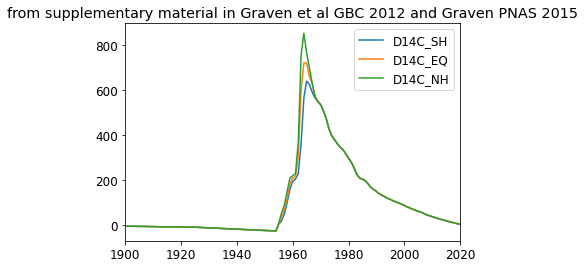

In [66]:
atmc14 = './c14dat/atmc14_mod.dat'
atmb14 = './c14dat/atmb14_mod.dat'

dfb14 = pd.read_csv(atmb14, delimiter=',')
dfc14 = pd.read_csv(atmc14, delimiter=',')
#
plt.figure()
plt.plot(dfb14['YEAR'],dfb14['D14C_SH'], label = 'D14C_SH')
plt.plot(dfb14['YEAR'],dfb14['D14C_EQ'], label = 'D14C_EQ')
plt.plot(dfb14['YEAR'],dfb14['D14C_NH'], label = 'D14C_NH')
plt.xlim([1900,2020])
plt.title('from supplementary material in Graven et al GBC 2012 and Graven PNAS 2015')
plt.legend()

## c14 and b14 variables

-11.886084
1.4079049


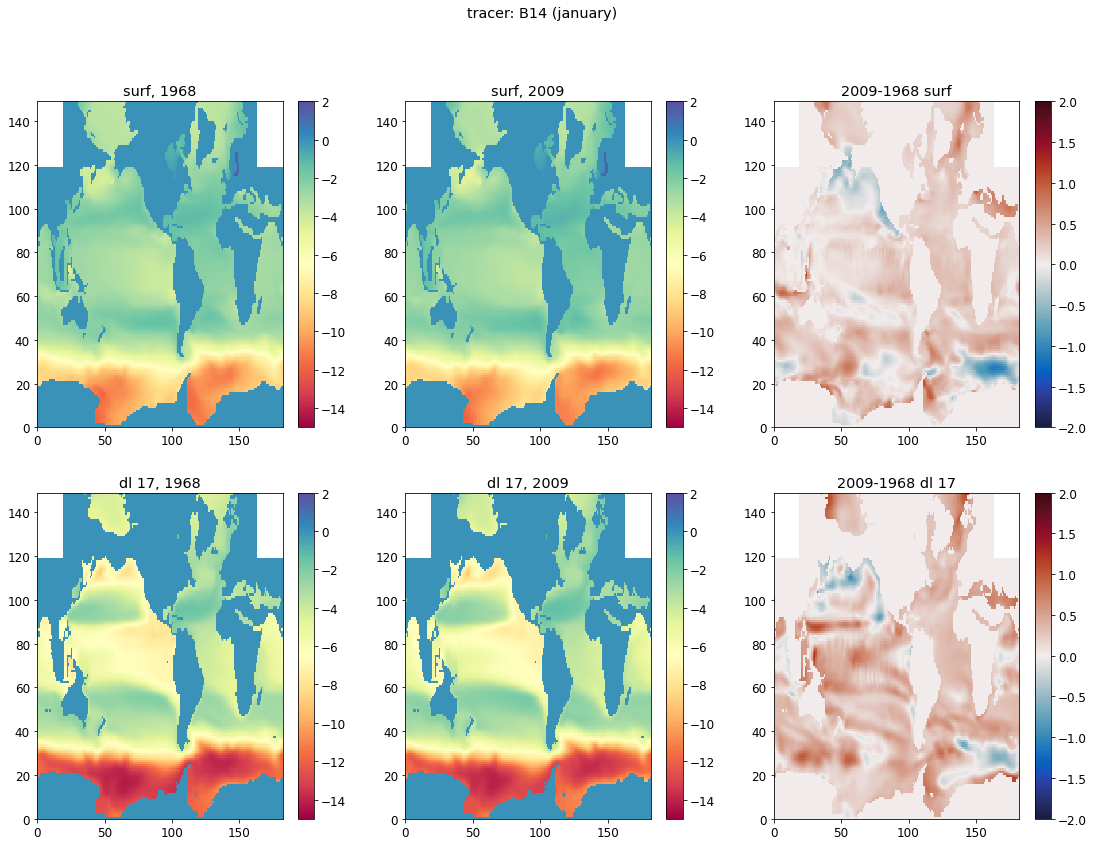

In [67]:
tdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_GEA4/'
f1 = xr.open_dataset(f'{tdir}/ORCA2_1m_19680101_19681231_ptrc_T.nc')
f2 = xr.open_dataset(f'{tdir}/ORCA2_1m_20090101_20091231_ptrc_T.nc')


fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(17*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tmin = -15; tmax = 2

print(np.nanmin(f1.B14B[0,0,:,:]))
print(np.nanmax(f1.B14B[0,0,:,:]))
w = axs[0].pcolormesh(f1.B14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[0])
w = axs[3].pcolormesh(f1.B14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[3])

w = axs[1].pcolormesh(f2.B14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[1])
w = axs[4].pcolormesh(f2.B14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[4])


w = axs[2].pcolormesh(f2.B14B[0,0,:,:]-f1.B14B[0,0,:,:], cmap = cm.balance, vmin = -2, vmax = 2)
plt.colorbar(w, ax = axs[2])
w = axs[5].pcolormesh(f2.B14B[0,17,:,:]-f1.B14B[0,17,:,:], cmap = cm.balance, vmin = -2, vmax = 2)
plt.colorbar(w, ax = axs[5])

plt.suptitle('tracer: B14 (january)')
tits = ['surf, 1968','surf, 2009', '2009-1968 surf',\
        'dl 17, 1968','dl 17, 2009', '2009-1968 dl 17',\
       ]
for i in range(0,6):
    
    axs[i].set_title(tits[i])

-9.748243
59.57702


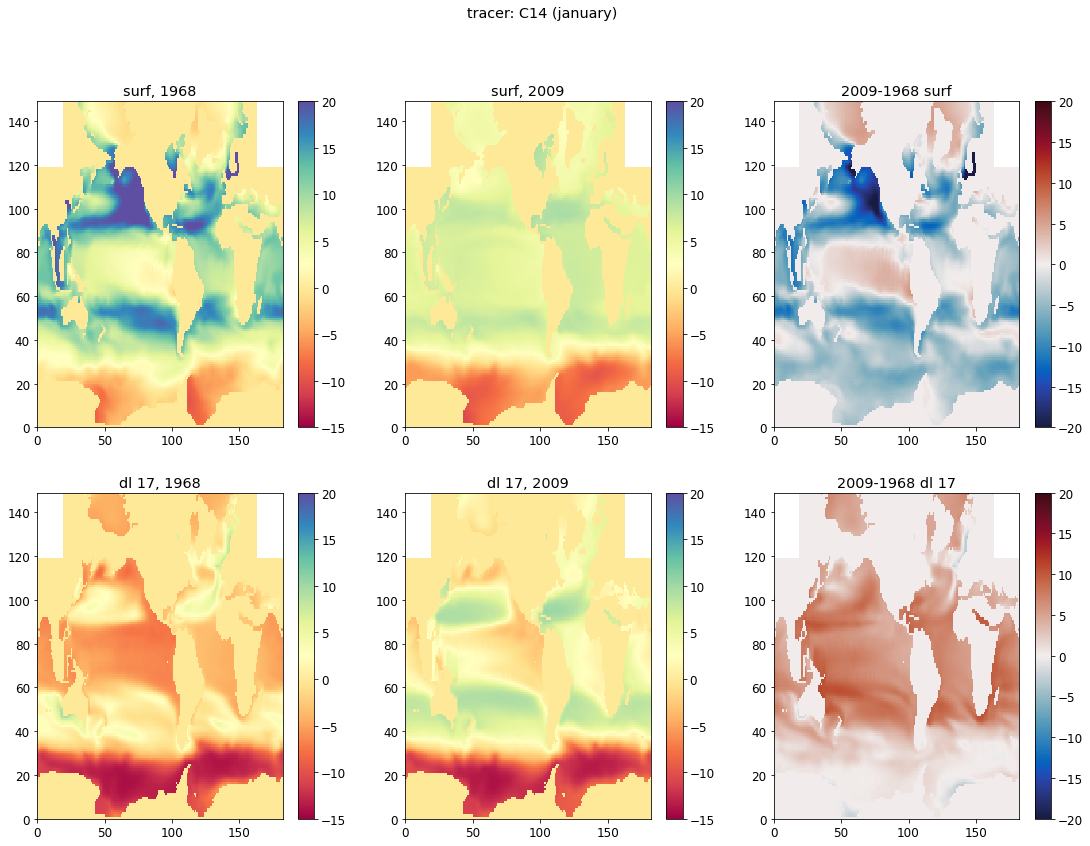

In [68]:
tdir = '/gpfs/afm/greenocean/software/runs/TOM12_TJ_GEA4/'
f1 = xr.open_dataset(f'{tdir}/ORCA2_1m_19680101_19681231_ptrc_T.nc')
f2 = xr.open_dataset(f'{tdir}/ORCA2_1m_20090101_20091231_ptrc_T.nc')


fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(17*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tmin = -15; tmax = 20

print(np.nanmin(f1.C14B[0,0,:,:]))
print(np.nanmax(f1.C14B[0,0,:,:]))
w = axs[0].pcolormesh(f1.C14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[0])
w = axs[3].pcolormesh(f1.C14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[3])

w = axs[1].pcolormesh(f2.C14B[0,0,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[1])
w = axs[4].pcolormesh(f2.C14B[0,17,:,:], cmap = 'Spectral', vmin = tmin, vmax = tmax)
plt.colorbar(w, ax = axs[4])


w = axs[2].pcolormesh(f2.C14B[0,0,:,:]-f1.C14B[0,0,:,:], cmap = cm.balance, vmin = -20, vmax = 20)
plt.colorbar(w, ax = axs[2])
w = axs[5].pcolormesh(f2.C14B[0,17,:,:]-f1.C14B[0,17,:,:], cmap = cm.balance, vmin = -20, vmax = 20)
plt.colorbar(w, ax = axs[5])

plt.suptitle('tracer: C14 (january)')
tits = ['surf, 1968','surf, 2009', '2009-1968 surf',\
        'dl 17, 1968','dl 17, 2009', '2009-1968 dl 17',\
       ]
for i in range(0,6):
    
    axs[i].set_title(tits[i])

## depth profiles of the variables in time

1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995
2000
2005
2010
2015
2020


Text(0.5, 0.98, 'depth profiles o f DIC, B14B, C14B through time for SO')

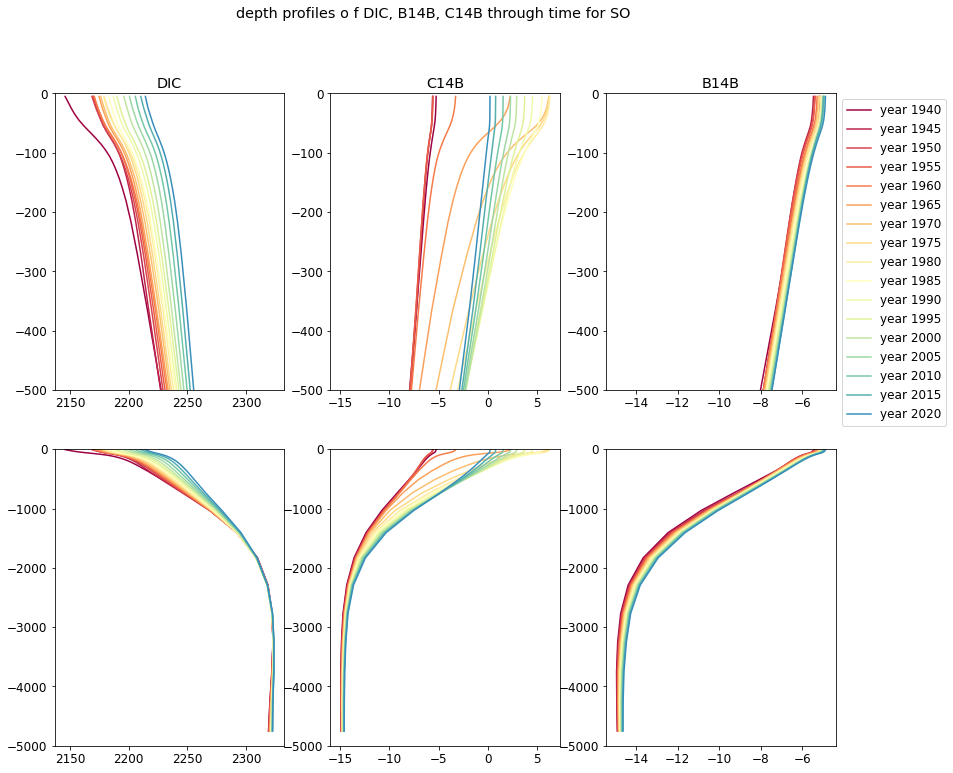

In [89]:
def make_yearlist(yrst, yrend,rnam):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dp_y{yr}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

# GEA4_d = xr.open_mfdataset(make_yearlist(1940,2022,'GEA4'))
# GEC4_d = xr.open_mfdataset(make_yearlist(1940,2022,'GEC4'))



fact = 1.0
fig, axs = plt.subplots(2,3, figsize=(14*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#cmap = 'Spectral'
tcm = plt.cm.get_cmap('Spectral')#plt.Spectral #cm.phase
rnam = 'GEA4'
rs = 18

for i in range(0,17):
    
    yr = 1940+i*5
    print(yr)
    ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dp_y{yr}.nc'
    
    t2 = xr.open_dataset(glob.glob(ty)[0])
    axs[0].plot(t2.DIC[:]*1e6,-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')
    axs[3].plot(t2.DIC[:]*1e6,-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')

    axs[1].plot(t2.C14B[:],-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')
    axs[4].plot(t2.C14B[:],-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')

    axs[2].plot(t2.B14B[:],-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')
    axs[5].plot(t2.B14B[:],-t2.deptht, color = tcm(1.*(i)/rs), label = f'year {i*5 + 1940}')


axs[0].set_ylim([-500,0])

axs[1].set_ylim([-500,0])
axs[2].set_ylim([-500,0])

axs[3].set_ylim([-5000,0])
axs[4].set_ylim([-5000,0])
axs[5].set_ylim([-5000,0])

axs[2].legend(bbox_to_anchor = [1,1])

axs[0].set_title('DIC');axs[1].set_title('C14B'); axs[2].set_title('B14B');
# axs[0].set_xlabel('$\mu$ mol L$^{-1}$')
# axs[0].set_ylabel('m')


fig.suptitle('depth profiles o f DIC, B14B, C14B through time for SO')

1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


Text(0.5, 0.98, 'DIC, B14B, C14B through time for SO at depth level 0 and depth level 17 (python)')

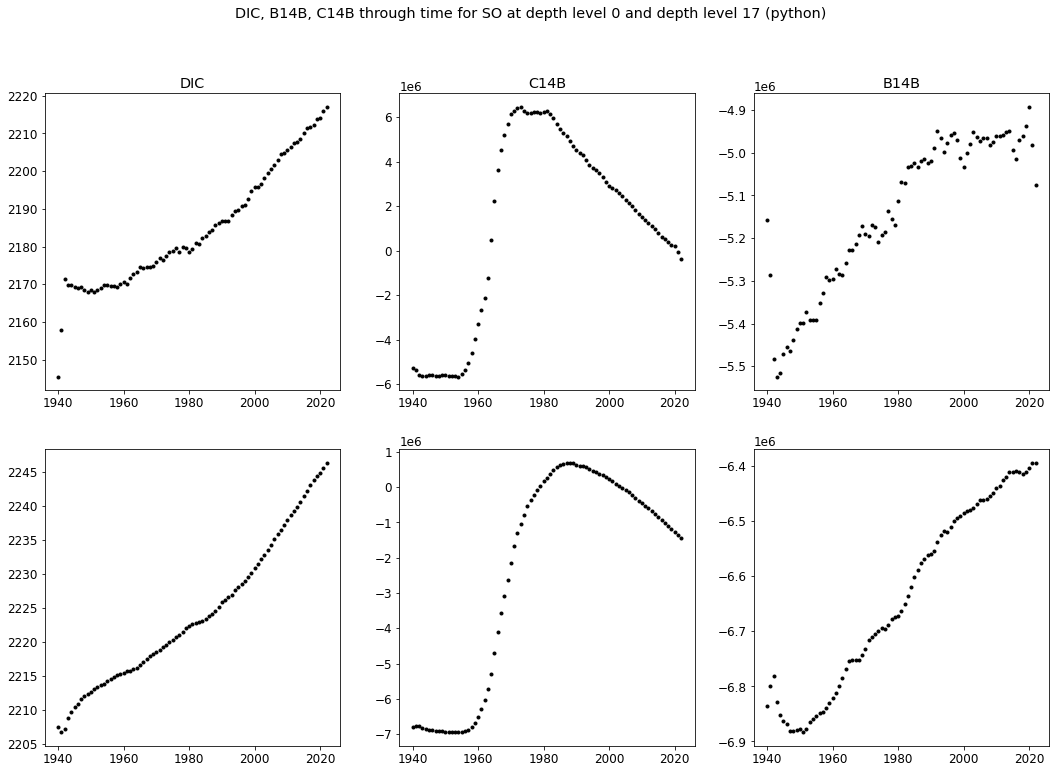

In [88]:
def make_yearlist(yrst, yrend,rnam):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dp_y{yr}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

# GEA4_d = xr.open_mfdataset(make_yearlist(1940,2022,'GEA4'))
# GEC4_d = xr.open_mfdataset(make_yearlist(1940,2022,'GEC4'))



fact = 1.0
fig, axs = plt.subplots(2,3, figsize=(18*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

#cmap = 'Spectral'
tcm = plt.cm.get_cmap('Spectral')#plt.Spectral #cm.phase
rnam = 'GEA4'
rs = 18

for i in range(0,83):
    
    yr = 1940+i
    print(yr)
    ty = f'/gpfs/home/mep22dku/scratch/C14/GCBdata/grad/{rnam}_dp_y{yr}.nc'
    
    t2 = xr.open_dataset(glob.glob(ty)[0])
    axs[0].scatter(yr,t2.DIC[0]*1e6,marker = '.', color = 'k')
    axs[3].scatter(yr,t2.DIC[17]*1e6,marker = '.', color = 'k')

    axs[1].scatter(yr,t2.C14B[0]*1e6,marker = '.', color = 'k')
    axs[4].scatter(yr,t2.C14B[17]*1e6,marker = '.', color = 'k')
    
    axs[2].scatter(yr,t2.B14B[0]*1e6,marker = '.', color = 'k')
    axs[5].scatter(yr,t2.B14B[17]*1e6,marker = '.', color = 'k')


axs[0].set_title('DIC');axs[1].set_title('C14B'); axs[2].set_title('B14B');
# axs[0].set_xlabel('$\mu$ mol L$^{-1}$')
# axs[0].set_ylabel('m')


fig.suptitle('DIC, B14B, C14B through time for SO at depth level 0 and depth level 17 (python)')